# i3sense Import and process data for small samples of water uptake

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import logging
import scipy.stats as stats

In [2]:
# %cd {"/home/jupyter-bara/01_i3sense"}

## Load data
excel with two lists referencni and mereni_uzavrene
first row is reference values - beggining at time 15:07 - before some oscilations

In [3]:
df = pd.read_excel("small_uzavrene.xlsx", sheet_name = None)

# check sheet names
for sheet_name, names in df.items():
    print(f"Sheet name: {sheet_name}")
    print(names.head())  # or print(df) if you want the full table
    print("-" * 40)

Sheet name: referencni
                  cas  temp (°C)   RH (%)   m1 (g)   m2 (g)   m3 (g)   m4 (g)  \
0 2024-10-27 19:09:32    22.1982  49.6412  50.4833  56.1041  76.1091  61.5808   
1 2024-10-27 19:10:32    21.9837  49.5496  50.4819  56.1091  76.1059  61.5819   
2 2024-10-27 19:11:33    21.9086  49.4504  50.4828  56.1088  76.1116  61.5821   
3 2024-10-27 19:12:33    21.9622  49.4886  50.4849  56.1165  76.1125  61.5823   
4 2024-10-27 19:13:33    21.8979  49.8777  50.4846  56.1106  76.1186  61.5821   

    m5 (g)  
0  62.8388  
1  62.8401  
2  62.8429  
3  62.8450  
4  62.8474  
----------------------------------------
Sheet name: mereni_uzavrene
                  cas  temp (°C)   RH (%)   m1 (g)   m2 (g)   m3 (g)   m4 (g)  \
0 2024-10-29 15:07:38    24.6542  48.4128  50.3823  71.0868  60.1425  59.4147   
1 2024-10-29 15:08:38    24.6328  48.9393  50.3817  71.1526  60.1697  59.4641   
2 2024-10-29 15:09:38    24.5363  49.3131  50.3835  71.2151  60.1814  59.4774   
3 2024-10-29 15:10:

## extrakt list of measured values and plotting

<Axes: >

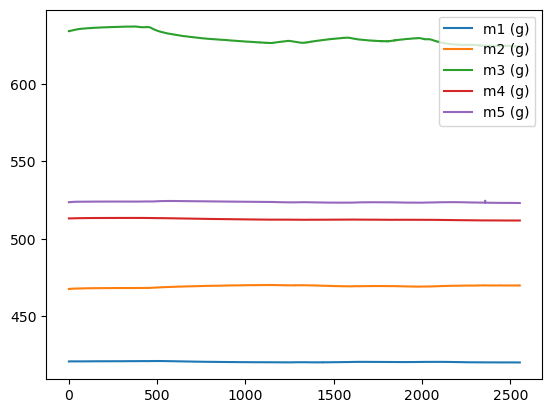

In [4]:
# from 1sheet - reference values calculate densities
ref = df["referencni"]
ref
#dens = (ref['m1 (g)']/1000)/(0.02*0.02*0.3)
#dens
dens = pd.DataFrame()

for i in range(1, 6):  # for samples 2 to 5
    mass_col = f"m{i} (g)"
    dens[mass_col] = (ref[mass_col] / 1000) / (0.02 * 0.02 * 0.3)

# use the last density of m2 sample as reference for rho_0 - input in comsol
rho_refm2 = dens['m2 (g)'].iloc[-1]
rho_refm2

dens.plot ()

Text(0, 0.5, 'm (g)')

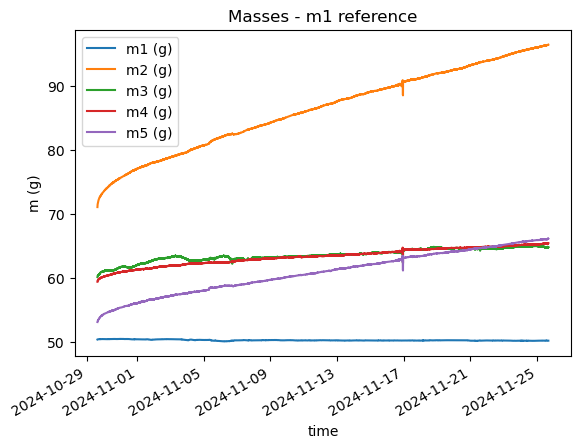

In [5]:
df = df["mereni_uzavrene"]
m = df

# plot data of mass - absolute values
m.drop(["temp (°C)","RH (%)"], axis=1).plot(x="cas", subplots=False)
plt.title ('Masses - m1 reference')
plt.xlabel ('time')
plt.ylabel ('m (g)')

In [6]:
#df['List1'].drop(["t","r"], axis=1).plot(x="cas", subplots=True)

## Mass and water mass increment

In [7]:
# Prepare table
# Columns to keep unchanged
unchanged_cols = ["temp (°C)", "RH (%)"]

# Separate datetime column
datetime_col = "cas"

# Numeric columns (excluding unchanged)
numeric_cols = m.select_dtypes(include='number').columns.difference(unchanged_cols)

# Create a copy to store results
m_delta = m.copy()

# Mass incremenent calculation
# Subtract numeric columns
m_delta[numeric_cols] = m[numeric_cols] - m.iloc[0][numeric_cols]

# Subtract datetime separately
m_delta[datetime_col] = m[datetime_col] - m.iloc[0][datetime_col]

# Water mass incerement calculation
# relative value of reference sample
m_delta["m1_rel"] = m["m1 (g)"]/m["m1 (g)"].iloc[0] 

# water mass increase 
#m_delta ["water_mass 2 (g)"] = m_delta["m1_rel"] * m_delta["m2 (g)"]

for i in range(2, 6):  # for samples 2 to 5
    mass_col = f"m{i} (g)"
    water_col = f"water_mass {i} (g)"
    m_delta[water_col] = m_delta["m1_rel"] * m_delta[mass_col]

# plot table
m_delta

,cas,temp (°C),RH (%),m1 (g),m2 (g),m3 (g),m4 (g),m5 (g),m1_rel,water_mass 2 (g),water_mass 3 (g),water_mass 4 (g),water_mass 5 (g)
0,0 days 00:00:00,24.6542,48.4128,0.0,0.0,0.0,0.0,0.0,1.000000,0.0,0.0,0.0,0.0
1,0 days 00:01:00,24.6328,48.9393,-0.0006,0.0658,0.0272,0.0494,0.0354,0.999988,0.065799,0.0272,0.049399,0.0354
2,0 days 00:02:00,24.5363,49.3131,0.0012,0.1283,0.0389,0.0627,0.0356,1.000024,0.128303,0.038901,0.062701,0.035601
3,0 days 00:03:00,24.4183,49.9158,0.0056,0.1428,0.0305,0.0599,0.0391,1.000111,0.142816,0.030503,0.059907,0.039104
4,0 days 00:04:00,24.4826,48.4510,0.002,0.2056,0.0648,0.095,0.0657,1.000040,0.205608,0.064803,0.095004,0.065703
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38664,27 days 00:55:57,25.3299,38.3878,-0.1855,25.3863,4.6574,6.0098,13.0182,0.996318,25.292831,4.640252,5.987673,12.970269
38665,27 days 00:56:57,25.3299,35.1377,-0.185,25.3981,4.6515,6.015,13.0182,0.996328,25.30484,4.63442,5.992913,12.970398
38666,27 days 00:57:57,25.3192,38.8151,-0.1849,25.3903,4.6562,6.0098,13.0092,0.996330,25.297119,4.639112,5.987744,12.961457
38667,27 days 00:58:57,25.3085,36.9306,-0.1839,25.3932,4.6462,6.0092,13.0044,0.996350,25.300512,4.629241,5.987266,12.956933


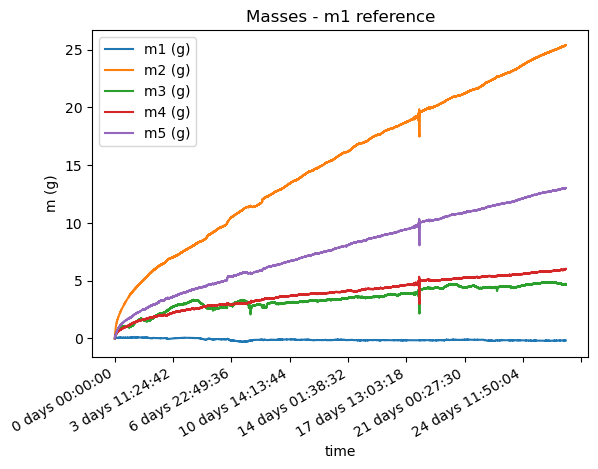

In [8]:
## plot data Masses
# Dynamically find all 'water_mass' columns
masses_cols = [col for col in m_delta.columns if col.startswith("m") and " (g)" in col]

# Now plot them
m_delta.plot(x="cas", y=masses_cols)

# Add labels and title
plt.title('Masses - m1 reference')
plt.xlabel('time')
plt.ylabel('m (g)')
plt.show()

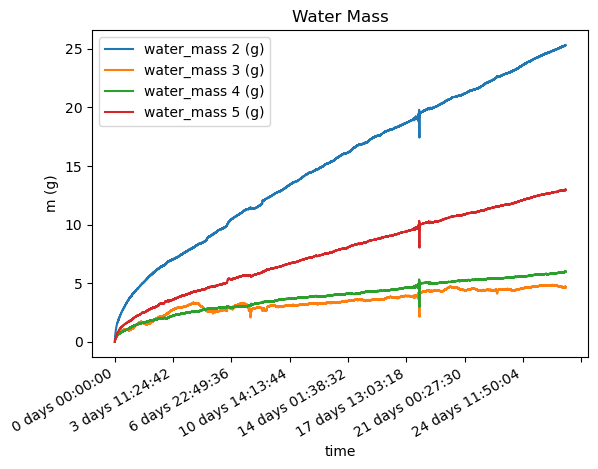

In [9]:
## plot data Water Masse
# Dynamically find all 'water_mass' columns
water_cols = [col for col in m_delta.columns if col.startswith("water_mass")]

# Now plot them
m_delta.plot(x="cas", y=water_cols)

# Add labels and title
plt.title('Water Mass')
plt.xlabel('time')
plt.ylabel('m (g)')
plt.show()

## RVD (EMC) for boundary conditions

<Axes: xlabel='cas'>

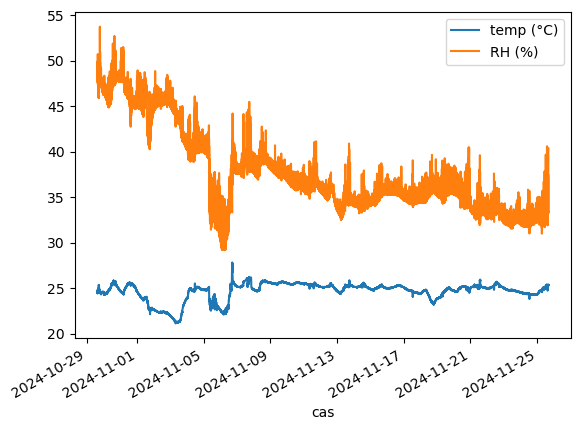

In [10]:
m.plot (x='cas',y=["temp (°C)","RH (%)"])

## Wood moisture based on Anderson - McCarty Sorption

In [11]:
# Value A eq. 4.38a, Horacek 1998 constants are given
A = 7.731706 - 0.014348 * (m_delta["temp (°C)"]+273.5)
A

0        3.453790
1        3.454097
2        3.455481
3        3.457174
4        3.456252
           ...   
38664    3.444095
38665    3.444095
38666    3.444248
38667    3.444402
38668    3.444248
Name: temp (°C), Length: 38669, dtype: float64

In [12]:
# Value B eq. 4.38a, Horacek 1998 constants are given
B = 0.008746 + 0.000567 * (m_delta["temp (°C)"]+273.5)
B

0        0.177799
1        0.177787
2        0.177733
3        0.177666
4        0.177702
           ...   
38664    0.178183
38665    0.178183
38666    0.178176
38667    0.178170
38668    0.178176
Name: temp (°C), Length: 38669, dtype: float64

In [13]:
# Moisture content by eq. 4.37b, Horacek 1998, the results in in %, therefore needs to be divided by 100
#
w = pd.DataFrame ()
w ["Time [min]"] = m_delta["cas"].dt.total_seconds() / 60
w ["EMC_amb"] = (1/B)*np.log(A/(np.log(1/(m_delta["RH (%)"]/100))))/100
w

,Time [min],EMC_amb
0,0.00,0.087767
1,1.00,0.088623
2,2.00,0.089275
3,3.00,0.090312
4,4.00,0.087917
...,...,...
38664,38935.95,0.071846
38665,38936.95,0.066886
38666,38937.95,0.072503
38667,38938.95,0.069632


<Axes: xlabel='Time [min]'>

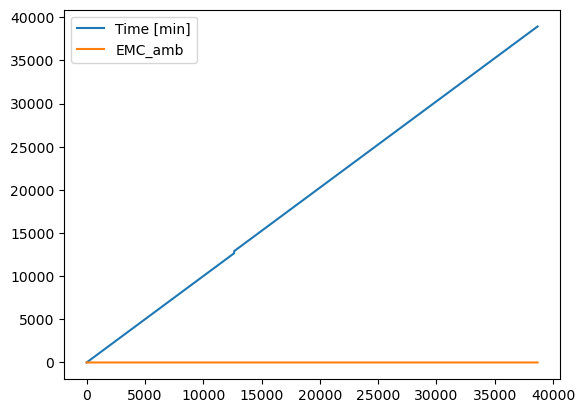

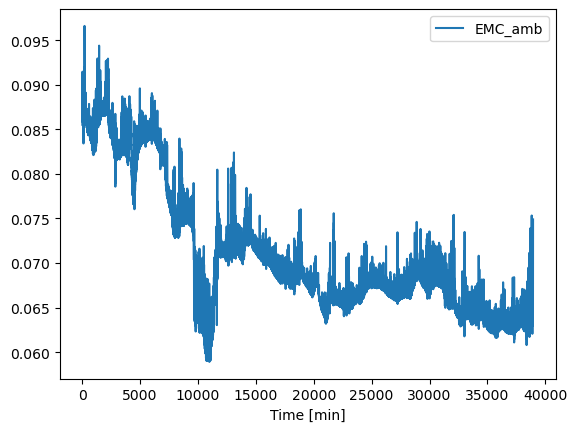

In [14]:
w.plot ()
w.plot(x='Time [min]',y=["EMC_amb"])

In [15]:
w.to_csv("EMC.csv", index = False)

## Density for input
Density as function of moisture (EMC)

In [16]:
# density of dry wood [kg/m3] based on literature values
rho_0 = 420 
rho_amb = rho_0*(1+w["EMC_amb"])/(1+0.993*rho_0*w["EMC_amb"])
rho_amb

0        12.149237
1        12.044451
2        11.965932
3        11.843384
4        12.130808
           ...    
38664    14.538698
38665    15.507396
38666    14.419891
38667    14.954639
38668    14.004627
Name: EMC_amb, Length: 38669, dtype: float64

In [17]:
rho_refm2

469.7991666666667

## Density by the equation with k_av
$$
rho_w = rho_0 * \frac{(1+EMC)}{(1 + k_{av} * EMC)}
$$


In [18]:
k_av = 0.5
#rho_0m2 = rho_refm2/1.17105
# zkontrolovat zavorky
rho_0m2 = rho_refm2*(1+k_av*0.11)/(1+0.11)
rho_0m2

446.5208295795795

In [19]:
rho_amb2 = pd.DataFrame ()

rho_amb2 ["rho_amb"] = rho_0m2*(1+w["EMC_amb"])/(1+k_av*w["EMC_amb"])
rho_amb2

,rho_amb
0,465.292024
1,465.467334
2,465.600798
3,465.812796
4,465.322627
...,...
38664,462.004877
38665,460.970532
38666,462.141650
38667,461.543760


In [20]:
rho_amb2.to_csv("rho_amb.csv", index=False)

## BL funkce paja

In [ ]:
# calculation of b_l function
c_w = 420

K_L = 1e-12

B_L = K_L * (-0.61 * (12400 * (c_w / 996.27)**(-0.61))) * (1 / c_w)
print(B_L)

#B_L
#K_L
#(c_b<=0.28,10^-12,(K_L*(-0.61*(12400*(c_w/996.27)^(-0.61)))*(1/c_w)))